### By Eu Jin Lee 

## Problem Statement

As a data scientist with the National Suicide Prevention Lifeline, we have been monitoring the posts on  SuicideWatch subreddit for suggestive intent of suicide among Redditors. This is in hopes that we may be able to intervene quickly and provide support. 

However, we came across a problem when the reddit 

## Executive Summary

## Contents 

- [Data Dictionary](#Data-Dictionary)
- [Import Packages](#Import-Packages)
- [Collecting Reddit Posts and Building Dataframe](#Collecting-Reddit-Posts-and-Building-Dataframe)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Reference](#Reference)

## Data Dictionary

## Import Packages 

In [55]:
#Standard Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Web Request Package
import requests

#Modeling Packages 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

#Misc Packages
import datetime as dt
import time
from better_profanity import profanity  

pd.set_option('display.max_columns', 100)

## Collecting Reddit Posts and Building Dataframe

In [2]:
# here's an example query url
url = "https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch"

In [3]:
res = requests.get(url)

In [4]:
# Explicitly get the status code
res.status_code

200

In [5]:
# Convert the string to JSON, or dictionary, format
json_data = res.json()

In [6]:
posts = pd.DataFrame(json_data['data'])

In [106]:
#Creates the initial dataframe 
#1000 most recent comments at present time (1595206333)
url = "https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1595206333&sort=des&size=1000"
headers = {'User-agent': 'ejlee'}
res = requests.get(url)
json = res.json()
postssw = pd.DataFrame(json['data'])

postssw = postssw[['id','title','selftext','subreddit','created_utc','author','score','num_comments']]
#Filters for deleted posts
postssw = postssw[postssw['selftext']!='[deleted]']
postssw = postssw[postssw['selftext'] != '[removed]']
postssw = postssw[postssw['author'] != '[deleted]']

#Loops backward over 12 day intervals, adding the 1000 most recent comments prior to each timepoint
for i in range(1,80):
    url = "https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before={}&sort=des&size=1000".format(1595206333 - i*1036800)
    headers = {'User-agent': 'ejlee'}
    print(url)
    res = requests.get(url)
    json = res.json()
    postbloc = pd.DataFrame(json['data'])
    postbloc = postbloc[['id','title','selftext','subreddit','created_utc','author','score','num_comments']]
    postbloc = postbloc[postbloc['selftext']!='[deleted]']
    postbloc = postbloc[postbloc['selftext'] != '[removed]']
    postbloc = postbloc[postbloc['author'] != '[deleted]']
    postssw = pd.concat([postssw, postbloc], ignore_index=True)
    time.sleep(1)

https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1594169533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1593132733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1592095933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1591059133&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1590022333&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1588985533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1587948733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1586911933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1585875133&sort=des&size=1000
https://ap

https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1516409533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1515372733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1514335933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1513299133&sort=des&size=1000


In [107]:
len(postssw)

7350

In [108]:
#Creates the initial dataframe 
#1000 most recent comments at present time (1595206333)
url = "https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1595206333&sort=des&size=1000"
headers = {'User-agent': 'ejlee'}
res = requests.get(url)
json = res.json()
postsomc = pd.DataFrame(json['data'])

postsomc = postsomc[['id','title','selftext','subreddit','created_utc','author','score','num_comments']]
#Filters for deleted posts
postsomc = postsomc[postsomc['selftext']!='[deleted]']
postsomc = postsomc[postsomc['selftext'] != '[removed]']
postsomc = postsomc[postsomc['author'] != '[deleted]']

#Loops backward over 12 day intervals, adding the 1000 most recent comments prior to each timepoint
for i in range(1,80):
    url = "https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before={}&sort=des&size=1000".format(1595206333 - i*1036800)
    headers = {'User-agent': 'ejlee'}
    res = requests.get(url)
    print(url)
    json = res.json()
    postbloc = pd.DataFrame(json['data'])
    postbloc = postbloc[['id','title','selftext','subreddit','created_utc','author','score','num_comments']]
    postbloc = postbloc[postbloc['selftext']!='[deleted]']
    postbloc = postbloc[postbloc['selftext'] != '[removed]']
    postbloc = postbloc[postbloc['author'] != '[deleted]']
    postsomc = pd.concat([postsomc, postbloc], ignore_index=True)
    time.sleep(1)

https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1594169533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1593132733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1592095933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1591059133&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1590022333&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1588985533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1587948733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1586911933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1585875133&sort=des&size=1000
https://api.pushshift.io/red

https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1515372733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1514335933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1513299133&sort=des&size=1000


In [109]:
len(postsomc)

6783

In [117]:
posts = pd.concat([postssw, postsomc])
posts = posts.reset_index(drop=True)
posts.head()

,id,title,selftext,subreddit,created_utc,author,score,num_comments
0,hubrwp,I feel like I don't belong anywhere,"Just tired.\nEverytime I try to get better, so...",SuicideWatch,1595206177,madgalvcg,2,1
1,hubqgq,Death,For some people death is the end of happiness ...,SuicideWatch,1595206028,whateverdie,1,6
2,hubnpm,Sooner than expected,"I know ive set a date before, but I'm probably...",SuicideWatch,1595205714,GreatKnightArtorias,3,0
3,hubna0,My financial situation amongst other things ha...,Things have gone very downhill for me on the p...,SuicideWatch,1595205664,CoreyNTrevorLahey,3,0
4,hubksf,don’t know what to do anymore.,all i do is sleep. last night i went to sleep ...,SuicideWatch,1595205376,lilpeep11321,1,6


In [118]:
posts.shape

(14133, 8)

In [119]:
#Import Regex
import re

#This function selects any consecutive combination of \r's and \n's in a bloc of text, 
#and replaces that selection with a single space.
def replace_linebreaks_w_space(x):
    return re.sub('([\r\n]+)',' ',x)

#This function selects any stretch of two or more consecutive spaces in a bloc of text,
#and replaces that selection with a single space.
def replace_multispace_w_space(x):
    return re.sub('([ ]{2,})',' ',x)

#Here we take every comment and apply the two functions to it.
posts['selftext'] = posts['selftext'].map(replace_linebreaks_w_space)
posts['selftext'] = posts['selftext'].map(replace_multispace_w_space)

In [120]:
#Strip away any spaces at the beginning or end of each comment, splits the comment into a list of words, 
#and returns the length of that list (i.e.; the number of words in the comment)
posts['word_length'] = posts['selftext'].map(lambda x: len(x.strip().split(' ')))

In [122]:
posts.head()

,id,title,selftext,subreddit,created_utc,author,score,num_comments,word_length
0,hubrwp,I feel like I don't belong anywhere,"Just tired. Everytime I try to get better, som...",SuicideWatch,1595206177,madgalvcg,2,1,100
1,hubqgq,Death,For some people death is the end of happiness ...,SuicideWatch,1595206028,whateverdie,1,6,26
2,hubnpm,Sooner than expected,"I know ive set a date before, but I'm probably...",SuicideWatch,1595205714,GreatKnightArtorias,3,0,58
3,hubna0,My financial situation amongst other things ha...,Things have gone very downhill for me on the p...,SuicideWatch,1595205664,CoreyNTrevorLahey,3,0,159
4,hubksf,don’t know what to do anymore.,all i do is sleep. last night i went to sleep ...,SuicideWatch,1595205376,lilpeep11321,1,6,94


In [145]:
posts.dtypes

id              object
title           object
selftext        object
subreddit       object
created_utc      int64
author          object
score            int64
num_comments     int64
word_length      int64
dtype: object

In [123]:
posts['subreddit'].value_counts()

SuicideWatch    7350
offmychest      6783
Name: subreddit, dtype: int64

In [124]:
posts.to_csv('posts_final.csv',index=False)

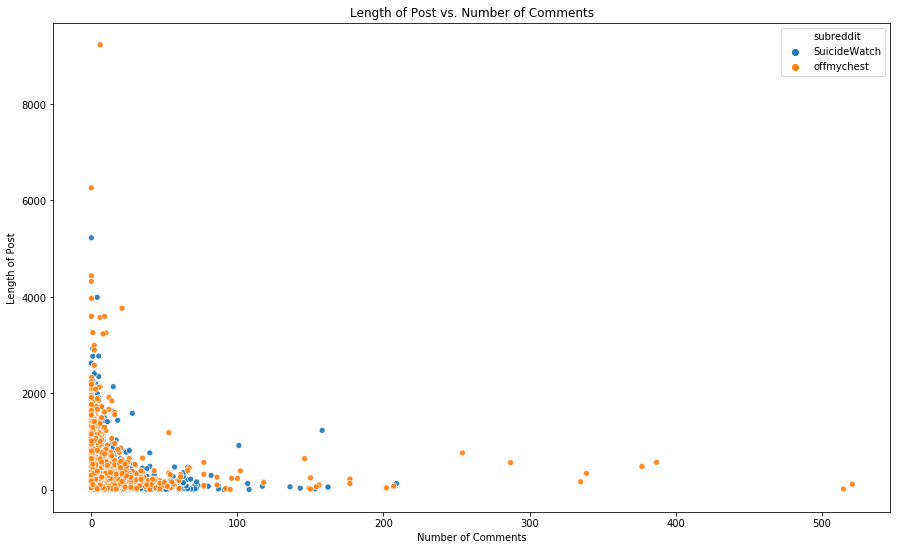

In [137]:
plt.figure(figsize=(15,9))
sns.scatterplot(posts['num_comments'],posts['word_length'],hue=posts['subreddit'], alpha=0.9)
plt.title('Length of Post vs. Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Length of Post');

## Building Classification Model for Reddit Post

### Instantiating feature and target variables

In [19]:
#Separate data into comment text (features) and subreddit (target variable)
X = posts['selftext']
y = posts['subreddit']

#Train test split. Stratify=y guarantees that class balance will be maintained across train and test bloc
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,stratify=y)

### Building a CountVectorizer, Logistic Regression Pipeline

In [99]:
#Creates pipeline to handle vectorization and logistic regression steps
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', LogisticRegression(solver='liblinear'))
     ])

#Specifies different hyperparameter values that we want to test across
params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

#Executes GridSearch
gs_lr1 = GridSearchCV(pipe, params, cv=4, verbose=3, n_jobs=-1)
gs_lr1.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.5min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l2', 'l1'], 'vect__min_df': [2, 5],
                         'vect__ngram_range': [(1, 3)],
                         'vect__stop_words': [None, 'english']},
             verbose=3)

In [100]:
#Training data accuracy score
gs_lr1.score(X_train, y_train)

0.9831116143032361

In [101]:
#Test data accuracy score
gs_lr1.score(X_test, y_test)

0.8203169213355971

In [102]:
#Shows us which hyperparameters were chosen
gs_lr1.best_estimator_.steps

[('vect', CountVectorizer(min_df=2, ngram_range=(1, 3))),
 ('model', LogisticRegression(C=0.1, solver='liblinear'))]

### Building a TFIDFVectorizer, Logistic Regression Pipeline

In [24]:
pipe2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs_lr2 = GridSearchCV(pipe2, params, cv=4, verbose=2, n_jobs=-1)
gs_lr2.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.8min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l2', 'l1'], 'vect__min_df': [2, 5],
                         'vect__ngram_range': [(1, 3)],
                         'vect__stop_words': [None, 'english']},
             verbose=2)

In [25]:
#Training data score
gs_lr2.score(X_train, y_train)

0.9933956033588074

In [26]:
#Test data score
gs_lr2.score(X_test, y_test)

0.8350311262026033

In [27]:
#Shows which hyperparameters were chosen
gs_lr2.best_estimator_.steps

[('vect', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
 ('model', LogisticRegression(C=10))]

### Building a TFIDFVectorizer, SVM Pipeline

In [48]:
posts_sample = posts.sample(n=707)

In [49]:
posts_sample.shape

(707, 8)

In [63]:
#Separate data into comment text (features) and subreddit (target variable)
X_sample = posts_sample['selftext']
y_sample = posts_sample['subreddit']

In [64]:
#Train test split. Stratify=y guarantees that class balance will be maintained across train and test bloc
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample,y_sample,shuffle=True,stratify=y_sample)

In [65]:
pipe3_sample = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', SVC())
     ])

params = {
    'vect__ngram_range':[(1,2)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__C':[0.1, 1, 10],
    'model__kernel': ['rbf','sigmoid','poly'],
    'model__degree': [1, 2, 3],
    'model__gamma':['auto','scale']
}

rs_svm_sample = RandomizedSearchCV(pipe3_sample,
                            params,
                            cv=5,
                            verbose=1,
                            n_jobs=-1)
rs_svm_sample.fit(X_sample_train, y_sample_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('model', SVC())]),
                   n_jobs=-1,
                   param_distributions={'model__C': [0.1, 1, 10],
                                        'model__degree': [1, 2, 3],
                                        'model__gamma': ['auto', 'scale'],
                                        'model__kernel': ['rbf', 'sigmoid',
                                                          'poly'],
                                        'vect__min_df': [2, 5],
                                        'vect__ngram_range': [(1, 2)],
                                        'vect__stop_words': [None, 'english']},
                   verbose=1)

In [67]:
#Training data score
rs_svm_sample.score(X_sample_train, y_sample_train)

1.0

In [68]:
#Test data score
rs_svm_sample.score(X_sample_test, y_sample_test)

0.7966101694915254

In [69]:
#Shows which hyperparameters were chosen
rs_svm.best_estimator_.steps

[('vect', TfidfVectorizer(min_df=5, ngram_range=(1, 2))),
 ('model', SVC(C=1, degree=2, gamma='auto', kernel='poly'))]

In [70]:
pipe3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', SVC())
     ])

params = {
    'vect__ngram_range':[(1,2)],
    'vect__min_df':[5],
    'vect__stop_words':[None,'english'],
    'model__C':[1],
    'model__kernel': ['poly'],
    'model__degree': [2],
    'model__gamma':['auto']
}

rs_svm = RandomizedSearchCV(pipe3,
                            params,
                            cv=4,
                            verbose=2,
                            n_jobs=-1)
rs_svm.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.7min finished


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('model', SVC())]),
                   n_jobs=-1,
                   param_distributions={'model__C': [1], 'model__degree': [2],
                                        'model__gamma': ['auto'],
                                        'model__kernel': ['poly'],
                                        'vect__min_df': [5],
                                        'vect__ngram_range': [(1, 2)],
                                        'vect__stop_words': [None, 'english']},
                   verbose=2)

In [72]:
rs_svm.score(X_train, y_train)

0.5200490612321917

In [80]:
rs_svm.score(X_test, y_test)

0.5200905489530278

In [47]:
rs_svm.best_estimator_.steps

[('vect', TfidfVectorizer(min_df=5, ngram_range=(1, 2))),
 ('model', SVC(C=1, degree=2, gamma='auto', kernel='poly'))]

### Building a TFIDFVectorizer, MultinomialNB Pipeline

In [76]:
pipe4 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', MultinomialNB())
     ])

params = {
    'vect__ngram_range':[(1,2)],
    'vect__min_df':[5],
    'vect__stop_words':[None,'english'],
    'model__fit_prior': [True,False],
    'model__alpha':[0.1,0.2,0.3,0.4,0.5]
}

rs_mnb = RandomizedSearchCV(pipe4,
                            params,
                            cv=5,
                            verbose=1,
                            n_jobs=-1)
rs_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.8s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('model', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'model__alpha': [0.1, 0.2, 0.3, 0.4,
                                                         0.5],
                                        'model__fit_prior': [True, False],
                                        'vect__min_df': [5],
                                        'vect__ngram_range': [(1, 2)],
                                        'vect__stop_words': [None, 'english']},
                   verbose=1)

In [81]:
rs_mnb.score(X_train, y_train)

0.9012170959524484

In [82]:
rs_mnb.score(X_test, y_test)

0.8225806451612904

In [83]:
rs_mnb.best_estimator_.steps

[('vect', TfidfVectorizer(min_df=5, ngram_range=(1, 2))),
 ('model', MultinomialNB(alpha=0.5))]

In [84]:
def fancy_confusion_matrix(y_test, preds):

    cmat = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    print(classification_report(y_test, preds))
    return pd.DataFrame(cmat, columns=['Predicted ' + str(i) for i in ['SuicideWatch','OffMyChest']],\
            index=['Actual ' + str(i) for i in ['SuicideWatch','OffMyChest']])

predicts = gs_lr2.predict(X_test)
fancy_confusion_matrix(y_test, predicts)

Accuracy: 0.8350311262026033
              precision    recall  f1-score   support

SuicideWatch       0.82      0.87      0.85      1838
  offmychest       0.85      0.80      0.82      1696

    accuracy                           0.84      3534
   macro avg       0.84      0.83      0.83      3534
weighted avg       0.84      0.84      0.83      3534



,Predicted SuicideWatch,Predicted OffMyChest
Actual SuicideWatch,1593,245
Actual OffMyChest,338,1358


In [85]:
coefs = pd.DataFrame(gs_lr2.best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['ngram'] = gs_lr2.best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['ngram','coef']]
coefs = coefs.sort_values('coef')
coefs.to_csv('data/coef_ranks.csv',index=False)

In [143]:
coefs.tail(30)

,ngram,coef
390472,men,2.964955
390473,really,2.968650
390474,him,3.012708
390475,about,3.030622
390476,hate life,3.049160
390477,that is all,3.050253
390478,off my chest,3.055074
390479,university,3.090620
390480,it been,3.091032
390481,my chest,3.122044


In [87]:
len(coefs)

390502

In [88]:
from wordcloud import WordCloud

SWWordCloud = coefs[0:200]
OMCWordCloud = coefs.sort_values('coef',ascending=False)[0:200]

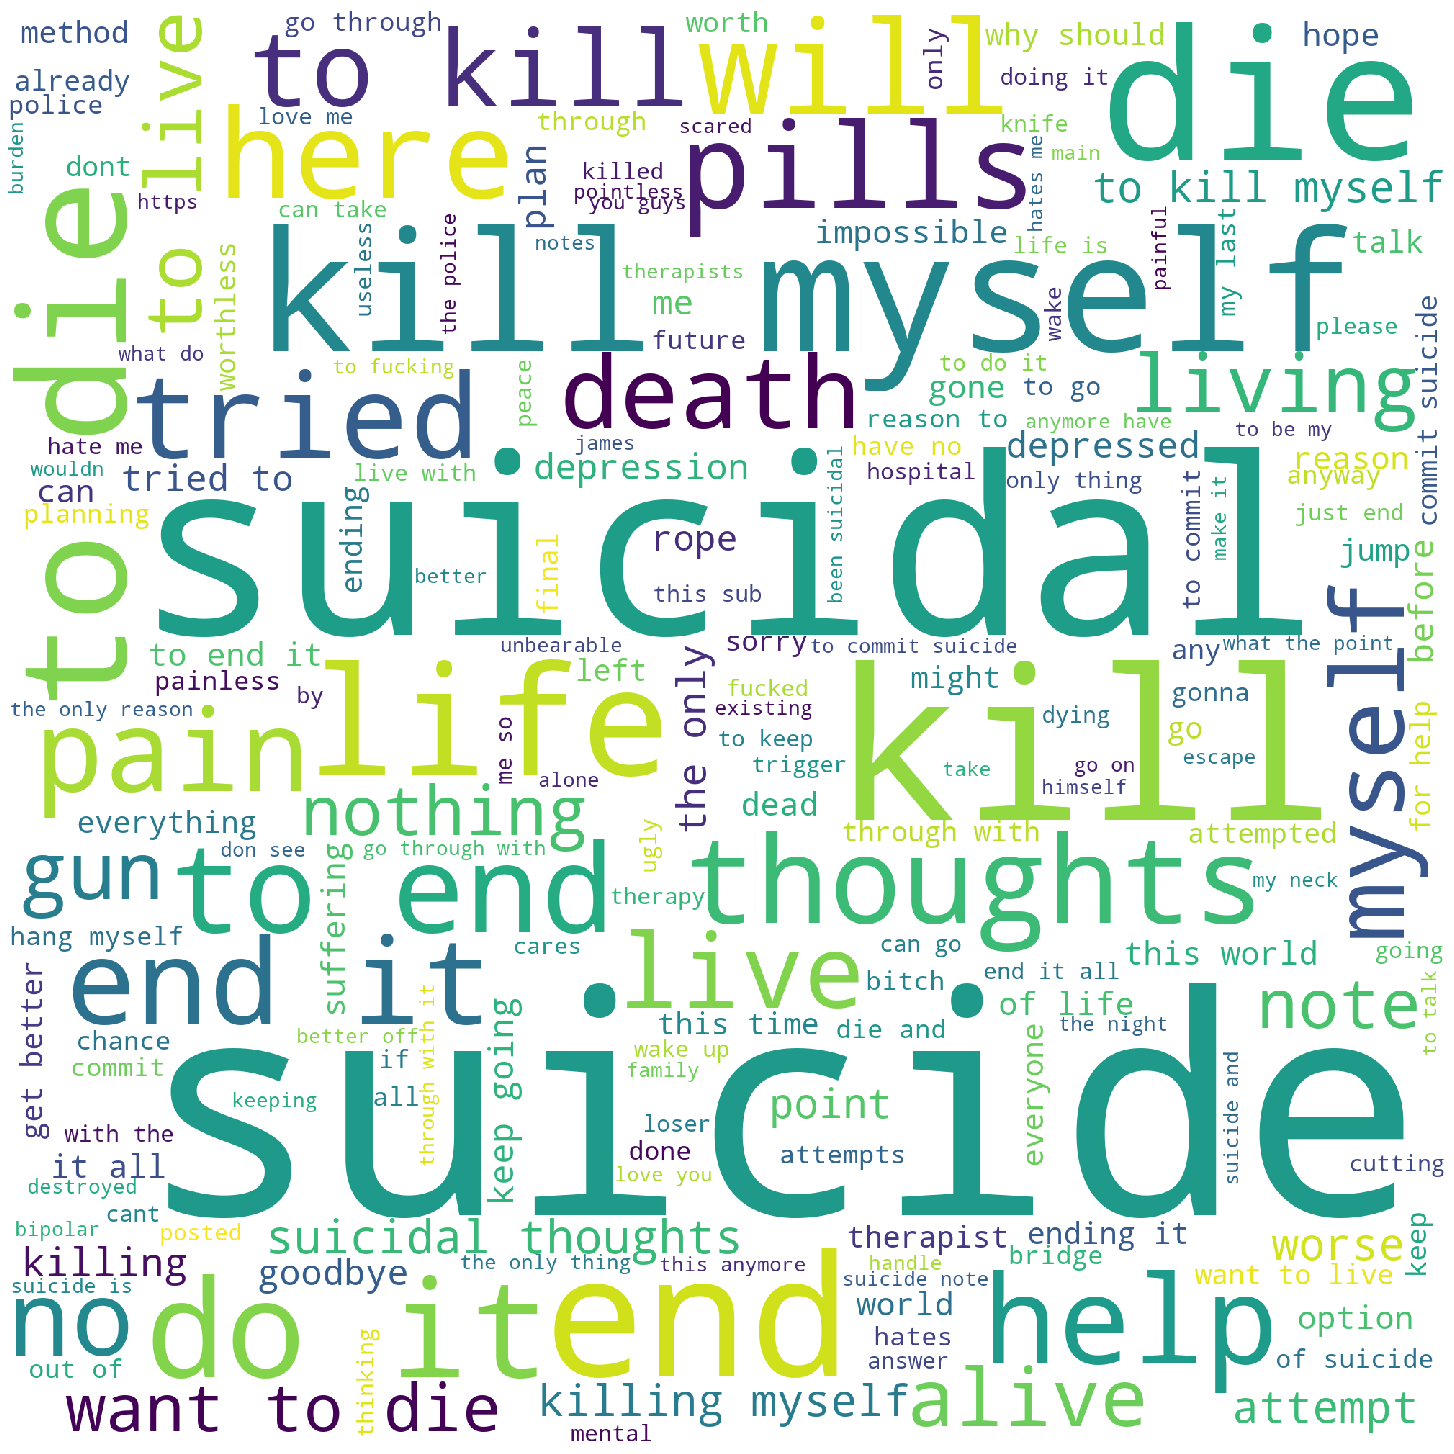

In [89]:
d={}
for key, val in SWWordCloud.values:
    d[key] = int(val**2)
    
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white',  
                min_font_size = 10).generate_from_frequencies(d)

plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

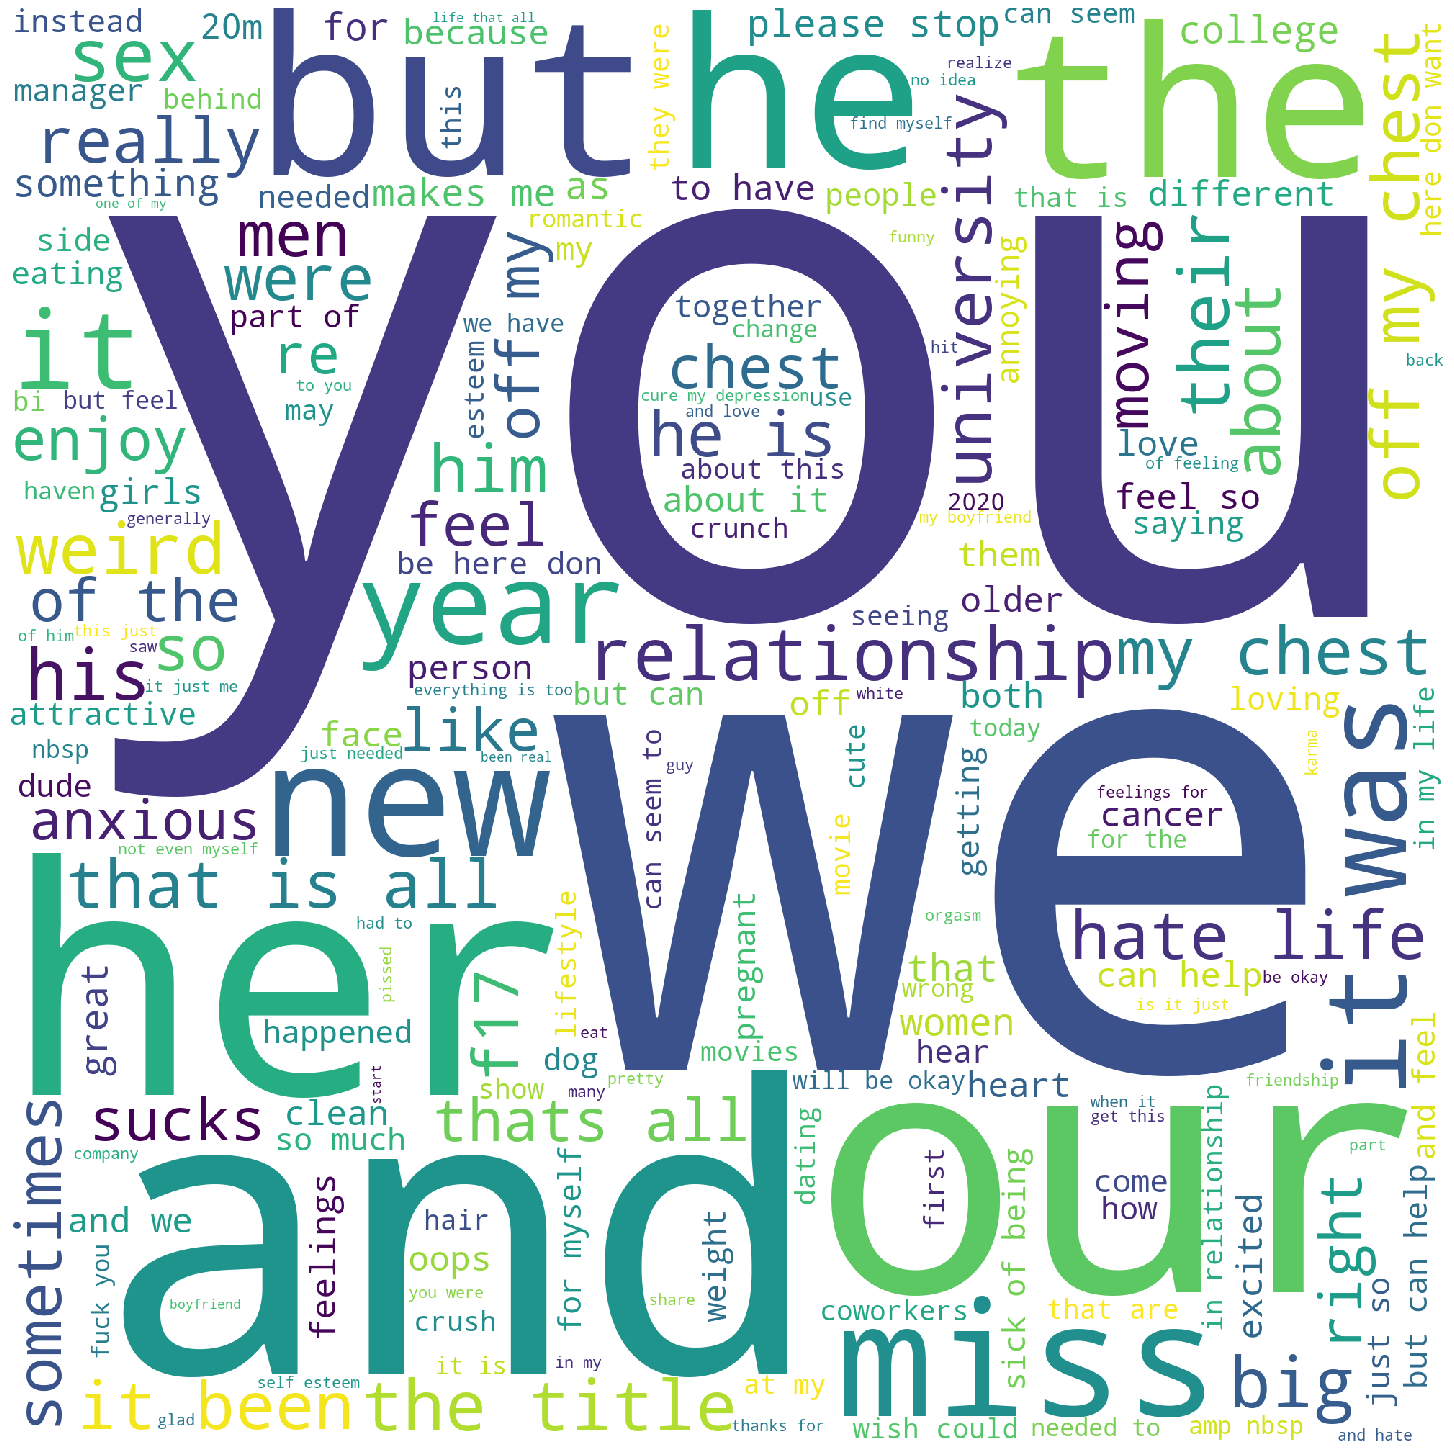

In [103]:
d={}
for key, val in OMCWordCloud.values:
    d[key] = int(val**2)
    
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white',  
                min_font_size = 10).generate_from_frequencies(d)

plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [90]:
#Puts predicted probabilities and associated text into a dataframe
predictions = pd.DataFrame(gs_lr2.predict_proba(X))
predictions['text'] = posts['selftext']

In [91]:
predictions.sort_values(1)[0:25]

,0,1,text
5387,0.999996,0.000004,I want to kill myself.
5463,0.999989,0.000011,I want to die.
1830,0.999951,0.000049,I WANT TO FUCKING KILL MYSELF I DON’T WANT TO ...
4875,0.999932,0.000068,I just want to die
820,0.999857,0.000143,I hate myself and i hate my life. I can't slee...
3261,0.999791,0.000209,i’ve tried to kill myself before and i thought...
6849,0.999789,0.000211,I really want to end it...............and i de...
1342,0.999775,0.000225,"i dont want to kill myself, i just really want..."
2778,0.999689,0.000311,i just want to die i wish there was a less pai...
7263,0.999590,0.000410,last week i took pills and tried to kill mysel...


In [92]:
def print_comment_if_string(string,post):
    if string.lower() in post.lower():
        print(post)
        print('-----')

In [93]:
#Just change the string and run the loop to search for comments
for i in posts['selftext']:
    print_comment_if_string('i can',i)

Just tired. Everytime I try to get better, something inside me say that is not right. My thoughts about end this shitty life became more and more strong everyday. I can't see any good things. I sent a message to the only person that I thought that would care about me and I know that's unfair but it seems no one care. I'm leaving little by little everyday and everyone thinks it's a joke. That's it I'm a joke I guess. I wish I have guts to ends this already, but I'm weak. Just wanna go and never come back...
-----
Things have gone very downhill for me on the past two years. I once was at a point where i was able to help family and friends when they were in a rut. I had a job that had me touring the country for most of the yesr every year. I never struggled financially in that time period. Nothing i needed to do was so out of reach that it was almost impossible... lately its been the exact opposite. I cant accomplish anything and no matter what i try to do something i cant accomplish it w

I recently had been having what felt like one of my best recovery periods in the 15 years I've been dealing with my depression. I have a good support network of family and friends that I had made sure to keep in the loop on how I was doing. I was doing well at work, finally feeling like I found something I could truly do as a career. I had found a diet and exercise plan that was working for me better than anything else had since I left the navy. I could feel myself on the edge of a depressive episode, but I was keeping it at bay with all the good things I was doing and with the help of my friends. Then I slipped up once and cheated on my diet. That's all, one little screw up. That's all it took for the self-hating voice in my head to start up with his usual "You're a worthless failure" shtick. And I couldn't drown him out, couldn't keep him quiet, couldn't make him go away once he got his foot in the door. And once he got his foot in the door, there was no stopping him. It was back to 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [94]:
predictions = pd.DataFrame(gs_lr2.predict_proba(X))
predictions['text'] = posts['selftext']
predictions['true'] = posts['subreddit']
predictions['pred'] = gs_lr2.predict(X)
predictions.columns = ['SuicideWatch','OffMyChest','text','true','pred']
predictions = predictions[['text','true','pred','SuicideWatch','OffMyChest']]

In [95]:
#Let's look at comments where the model guessed wrong.
wrong = predictions[predictions['true']!=predictions['pred']]

In [96]:
#Predicts SW strongly when the answer is OMC
wrong.sort_values('SuicideWatch',ascending=False).head(10)

,text,true,pred,SuicideWatch,OffMyChest
12367,People constantly go on and fucking on about h...,offmychest,SuicideWatch,0.996183,0.003817
12457,Im just so sick of people telling me to try an...,offmychest,SuicideWatch,0.994217,0.005783
13426,I have CRPS and live in constant physical pain...,offmychest,SuicideWatch,0.992446,0.007554
12144,Being a teen wih no power hard to get a job an...,offmychest,SuicideWatch,0.987967,0.012033
14062,Then I’m going to go to Home Depot and buy som...,offmychest,SuicideWatch,0.985023,0.014977
12378,This is just another venting post by just anot...,offmychest,SuicideWatch,0.983478,0.016522
12709,I had a dream where i was in a room talking to...,offmychest,SuicideWatch,0.977069,0.022931
7729,I'm a massive piece of shit. Pissing away ever...,offmychest,SuicideWatch,0.976463,0.023537
13358,I've already pushed away some of my close frie...,offmychest,SuicideWatch,0.971510,0.028490
10677,Being gay is just a nightmare that you can nev...,offmychest,SuicideWatch,0.969765,0.030235


In [97]:
#Predicts OMC strongly when the answer is SW
wrong.sort_values('OffMyChest',ascending=False)[31:40]

,text,true,pred,SuicideWatch,OffMyChest
1584,"So yeah..... He planned it, he struggled with ...",SuicideWatch,offmychest,0.110875,0.889125
1845,I’ve known Caroline(27F) for two years. She u...,SuicideWatch,offmychest,0.111648,0.888352
6836,the thing is my mom wants me to get 90 as an a...,SuicideWatch,offmychest,0.114852,0.885148
4803,Life... Life is never easy neither fair or is ...,SuicideWatch,offmychest,0.116363,0.883637
3329,"A week ago I was here, now this week I'm full ...",SuicideWatch,offmychest,0.117432,0.882568
1351,"A couple of weeks ago, I got into a fight with...",SuicideWatch,offmychest,0.117753,0.882247
3655,I struggled with suicidal ideation for a while...,SuicideWatch,offmychest,0.118323,0.881677
2814,I'm going to sound bitter as hell but everythi...,SuicideWatch,offmychest,0.123124,0.876876
5689,I fucking hate how I look. I've always hated h...,SuicideWatch,offmychest,0.125388,0.874612


In [98]:
from nltk.tokenize import RegexpTokenizer
coefs = pd.read_csv('data/coef_ranks.csv')

#Copy comment string in here, insert \ before apostrophes
comment = 'You need to be able to distinguish between a girl that likes the attention youre giving her from a girl that likes you. Most girls at a party will smile and talk to you if you approach them with confidence. After you talk to her though, you need to find a way for her to invest in the interaction. If she never invests in it you never really know what she wants. Walking away from the girl without getting any info is a good way to do this. You started the first conversation, now shes on the spot. If she doesnt come up to you and talk to you again, she isnt getting your number. This forces her to be more than just a receiver of attention. If youre leaving the party, or think you might not see her again at that party. Give her your contact info, dont take any of hers. Shes then forced to reach out to you if she wants things to go anywhere. Not only will this tell you if shes actually interested in you, it will make her more attracted. She will see that you arent desperate, and that makes you more attractive. Girls can sense when the only reason youre talking to them is to get their number or something like that. They can see right through you. When you walk away without the number, she realizes youre not just trying to get her number, you actually just wanted to talk to her. That is attractive'

#Converts comment to list of lowercase tokens
tokenizer = RegexpTokenizer(r'\w+')
comment_tokens = tokenizer.tokenize(comment.lower())

#Creates dataframe with words from comment, in order, with their coefficients
coef_list = []
for i in range(len(comment_tokens)):
    gram = comment_tokens[i]
    try:
        coef = coefs[coefs['ngram']==gram]['coef'].values[0]
    except:
        coef = np.nan
    coef_list.append(coef)   

d = {'gram':comment_tokens,'coef':coef_list}

df = pd.DataFrame(d).fillna(0)
df.to_csv('data/tableau_data.csv')

## Conclusion and Recommendations 